<a href="https://colab.research.google.com/github/tincho-mehaudy/DMCyT/blob/master/Majo_TP1_Consigna1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip -q install spotipy
!pip -q install -U librosa
#!wget -q https://www.dropbox.com/s/nqjs076fidighaz/SopSax.NoVib.mf.C4B4.wav?dl=1 -O SopSax.NoVib.mf.C4B4.wav

     |████████████████████████████████| 184kB 8.3MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib.pyplot as plt
import pandas as pd 
import spotipy 
import librosa
import librosa.display
import numpy as np
import matplotlib as mpl
import urllib.request
import seaborn as sns
import tqdm
import scipy
import joblib
from pathlib import Path
from IPython.display import Audio, Markdown, Image
from spotipy.oauth2 import SpotifyClientCredentials

# Números y Datos
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d

# Análisis de sonido
import librosa
import librosa.display
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

sns.set_context('poster')

# Consigna 1:

Utilizando la API de Spotify se descargó la información de 4092 pistas de audio. Cada registro tiene variables de features de alto (*audio_features*), bajo nivel (*audio_analysis*) y metadata de los tracks. La idea es limpiar los campos a utilizar y hacer un primer análisis de los datos.

Para facilitar los primeros pasos utilizar una pequeña porción aleatoria de los datos e ir aumentando progresivamente. Observación: los datos de *audio_analysis* pesan 1.3 GB

# Dataset *tracks* 

-   De los datos de *tracks*, separar las etiquetas que se podrán utilizar para la validación externa (Artista, Álbum, Año, Género), de los campos que no se utilizarán.

# Dataset *audio_features*

El dataset *audio_features* contiene atributos globales de alto nivel para cada pista de audio.

-   Con los datos de *audio_features*, generar un gráfico tipo *scatter matrix*.

-   Identificar variables más o menos informativas *a priori* y variables que requieran, además de la estandarización, alguna corrección para asimilar la distribución a una normal.

-   Estandarizar y volver a generar un gráfico tipo *scatter matrix*.

-   Identificar, si es que hay, valores extremos que sea necesario descartar.

# Dataset *audio_analysis*

El dataset *audio_analysis* contiene las variables continuas de bajo nivel, estimadas en ventanas temporales, como *timbre* o *pitches*. Como primer paso, deberán:

-   Resumir estas variables en valores por canción. Por ejemplo, tomar el promedio o el desvío estándar del timbre entre todas las ventanas, obteniendo 12 valores de timbre promedio y 12 valores de desvío estándar del timbre por canción.

-   Contruir un *data frame* con estos valores.

-   Generar un gráfico tipo *scatter matrix*.

-   Identificar variables más o menos informativas *a priori* y variables que requieran, además de la estandarización, alguna corrección para asimilar la distribución a una normal.

-   Estandarizar y volver a generar un gráfico tipo *scatter matrix*.

-   Identificar, si es que hay, valores extremos que sea necesario descartar.

## Bajamos los datos 



In [ ]:
!wget https://www.dropbox.com/s/ms6260jqmsmz5qu/audio_features.pickle?dl=1 -O audio_features.pickle
!wget https://www.dropbox.com/s/8d0y9bms80ly8ui/tracks.pickle?dl=1 -O tracks.pickle
!wget https://www.dropbox.com/s/1cmb8e8zvv6hsfs/audio_analysis.pickle?dl=1 -O audio_analysis.pickle

In [6]:
import pandas as pd
import numpy as np

df_af = pd.read_pickle('audio_features.pickle')
df_tracks = pd.read_pickle('tracks.pickle')
df_aa = pd.read_pickle('audio_analysis.pickle')

# Dataset *tracks* 

-   De los datos de *tracks*, separar las etiquetas que se podrán utilizar para la validación externa (Artista, Álbum, Año, Género), de los campos que no se utilizarán.

In [7]:
df_tracks.head()

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,is_local,name,popularity,preview_url,track_number,type,uri,genre
id,,,,,,,,,,,,,,,,,
4d3XHYFFuYYzxWr2cJ6yQl,"{'album_type': 'ALBUM', 'artists': [{'external...",Tommy Flanagan,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1,349600,False,{'isrc': 'USEWJ0702033'},{'spotify': 'https://open.spotify.com/track/4d...,https://api.spotify.com/v1/tracks/4d3XHYFFuYYz...,False,Angel Eyes - Studio,49,https://p.scdn.co/mp3-preview/10e213fc96d2f614...,3,track,spotify:track:4d3XHYFFuYYzxWr2cJ6yQl,jazz
3X3p3u03P8eFL8WTH0oaaU,"{'album_type': 'ALBUM', 'artists': [{'external...",Art Farmer,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1,344066,False,{'isrc': 'USBN29100147'},{'spotify': 'https://open.spotify.com/track/3X...,https://api.spotify.com/v1/tracks/3X3p3u03P8eF...,False,Fair Weather - Remastered,47,None,2,track,spotify:track:3X3p3u03P8eFL8WTH0oaaU,jazz
4KlXeaheot0OI9PoOWspvZ,"{'album_type': 'ALBUM', 'artists': [{'external...",Christian Scott aTunde Adjuah,"[CA, US]",1,348746,False,{'isrc': 'USC4R0714598'},{'spotify': 'https://open.spotify.com/track/4K...,https://api.spotify.com/v1/tracks/4KlXeaheot0O...,False,Cease Fire,13,None,5,track,spotify:track:4KlXeaheot0OI9PoOWspvZ,jazz
3j76McoUI18gDoqxYE14Bu,"{'album_type': 'ALBUM', 'artists': [{'external...",Skalpel,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1,275935,False,{'isrc': 'PLK281400008'},{'spotify': 'https://open.spotify.com/track/3j...,https://api.spotify.com/v1/tracks/3j76McoUI18g...,False,Sea,25,https://p.scdn.co/mp3-preview/d154ecaf7df8206c...,8,track,spotify:track:3j76McoUI18gDoqxYE14Bu,jazz
4zxd4tiXPlWMqoJltbVTbE,"{'album_type': 'ALBUM', 'artists': [{'external...",Miles Davis,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",2,284560,False,{'isrc': 'USSM15800962'},{'spotify': 'https://open.spotify.com/track/4z...,https://api.spotify.com/v1/tracks/4zxd4tiXPlWM...,False,Stella By Starlight,56,https://p.scdn.co/mp3-preview/a4430030bca4c02c...,3,track,spotify:track:4zxd4tiXPlWMqoJltbVTbE,jazz


In [8]:
df_tracks.columns

Index(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms',
       'explicit', 'external_ids', 'external_urls', 'href', 'is_local', 'name',
       'popularity', 'preview_url', 'track_number', 'type', 'uri', 'genre'],
      dtype='object')

Construimos un nuevo datasets de tracks con los atributos genero, artista, y album, del datasets de tracks.
Dentro del atributo album, de tipo diccionario, obtenemos además el nombre del album y la fecha del album correspondiente.

In [10]:
df_tracks2 = df_tracks[['artists','album','genre']]
df_tracks2['release_date'] =df_tracks2['album'].apply(pd.Series)['release_date'].apply(str)
df_tracks2['release_date'] =df_tracks2['release_date'].str.slice(0, 4)

df_tracks2['album_name'] =df_tracks2['album'].apply(pd.Series)['name'].apply(str)

df_tracks2.drop('album', inplace=True, axis=1)

df_tracks2.head()

,artists,genre,release_date,album_name
id,,,,
4d3XHYFFuYYzxWr2cJ6yQl,Tommy Flanagan,jazz,1991,Master Trio
3X3p3u03P8eFL8WTH0oaaU,Art Farmer,jazz,1958,Modern Art
4KlXeaheot0OI9PoOWspvZ,Christian Scott aTunde Adjuah,jazz,2014,Christian Scott Collection
3j76McoUI18gDoqxYE14Bu,Skalpel,jazz,2014,Transit
4zxd4tiXPlWMqoJltbVTbE,Miles Davis,jazz,1959,Kind Of Blue (Legacy Edition)


Analizamos si algunos registros carecen de la fecha del album.

In [11]:
# vemos los valores que no tenian fecha
df_tracks2[df_tracks2['release_date']=='0000']

,artists,genre,release_date,album_name
id,,,,
2qij1qbQCOkjB8gsu3Y5lH,Super8 & Tab,trance,0000,Black Is The New Yellow
0gAD3qvhN777Izfn3sRjiN,Super8 & Tab,trance,0000,Above & Beyond Presents Anjunabeats Volume 5
5tmXe6SOpaA2KnNoBgI42R,Above & Beyond,trance,0000,Above & Beyond Presents Anjunabeats Volume 5


Para los tres registros que no tenian fecha de album, hemos investigado con el nombre del album en internet e imputamos el valor faltante con su fecha.



In [12]:
# completo los valores faltantes
df_tracks2.loc['2qij1qbQCOkjB8gsu3Y5lH','release_date']='2010'
df_tracks2.loc['0gAD3qvhN777Izfn3sRjiN','release_date']='2007'
df_tracks2.loc['5tmXe6SOpaA2KnNoBgI42R','release_date']='2007'

# Dataset *audio_features*

El dataset *audio_features* contiene atributos globales de alto nivel para cada pista de audio.

-   Con los datos de *audio_features*, generar un gráfico tipo *scatter matrix*.

-   Identificar variables más o menos informativas *a priori* y variables que requieran, además de la estandarización, alguna corrección para asimilar la distribución a una normal.

-   Estandarizar y volver a generar un gráfico tipo *scatter matrix*.

-   Identificar, si es que hay, valores extremos que sea necesario descartar.


In [13]:
df_af.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
id,,,,,,,,,,,,,,,,,
6avAsaa2IsXHT2mtQ6cGVe,0.6040,0.9630,7,-4.622,1,0.1250,0.00284,0.846000,0.0769,0.2750,172.020,audio_features,spotify:track:6avAsaa2IsXHT2mtQ6cGVe,https://api.spotify.com/v1/tracks/6avAsaa2IsXH...,https://api.spotify.com/v1/audio-analysis/6avA...,388663,4
6fvu2d6gHAdiNCMco4lTxK,0.0677,0.0581,2,-25.662,0,0.0402,0.99400,0.567000,0.1170,0.0372,73.509,audio_features,spotify:track:6fvu2d6gHAdiNCMco4lTxK,https://api.spotify.com/v1/tracks/6fvu2d6gHAdi...,https://api.spotify.com/v1/audio-analysis/6fvu...,283653,3
5GmrXcVIMgLaaqKVxhi5kp,0.2590,0.2420,2,-15.790,1,0.0401,0.53000,0.000003,0.0714,0.3050,178.132,audio_features,spotify:track:5GmrXcVIMgLaaqKVxhi5kp,https://api.spotify.com/v1/tracks/5GmrXcVIMgLa...,https://api.spotify.com/v1/audio-analysis/5Gmr...,213640,3
1DMIHggF47tqsO468VUDmd,0.2420,0.4450,4,-7.421,0,0.0318,0.49400,0.000224,0.1860,0.0867,86.289,audio_features,spotify:track:1DMIHggF47tqsO468VUDmd,https://api.spotify.com/v1/tracks/1DMIHggF47tq...,https://api.spotify.com/v1/audio-analysis/1DMI...,247933,4
78Ovt1QkZbU1QBMKWpcXPy,0.7010,0.8060,9,-5.508,1,0.1480,0.18300,0.003750,0.1230,0.9750,147.150,audio_features,spotify:track:78Ovt1QkZbU1QBMKWpcXPy,https://api.spotify.com/v1/tracks/78Ovt1QkZbU1...,https://api.spotify.com/v1/audio-analysis/78Ov...,168112,4


Antes de continuar vamos a determinar el tipo de cada uno de atributos de nuestro dataset de features.


In [14]:
df_af.dtypes

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
uri                  object
track_href           object
analysis_url         object
duration_ms           int64
time_signature        int64
dtype: object

Para generar el gráfico de scatter matrix, vamos a seleccionar del datasets de features, solo las variables de tipo numérico, y en particular las continuas, esto es aquellas de tipo float64.


In [15]:
# construimos un datasets a partir del datasets de features original con la varibles continuas.
df_af_num = df_af
# sacamos las variables string
df_af_num.drop('analysis_url', inplace=True, axis=1)
df_af_num.drop('track_href', inplace=True, axis=1)
df_af_num.drop('uri', inplace=True, axis=1)
df_af_num.drop('type', inplace=True, axis=1)

# y las categoricas
df_af_num.drop('key', inplace=True, axis=1)
df_af_num.drop('mode', inplace=True, axis=1)
df_af_num.drop('time_signature', inplace=True, axis=1)
df_af_num.drop('duration_ms', inplace=True, axis=1)

Volvemos a revisar el tipo de los atributos de nuestro nuevo datasets.

In [16]:
df_af_num.dtypes

danceability        float64
energy              float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
dtype: object

A continuación vamos a generar un gráfico tipo scatter matrix.



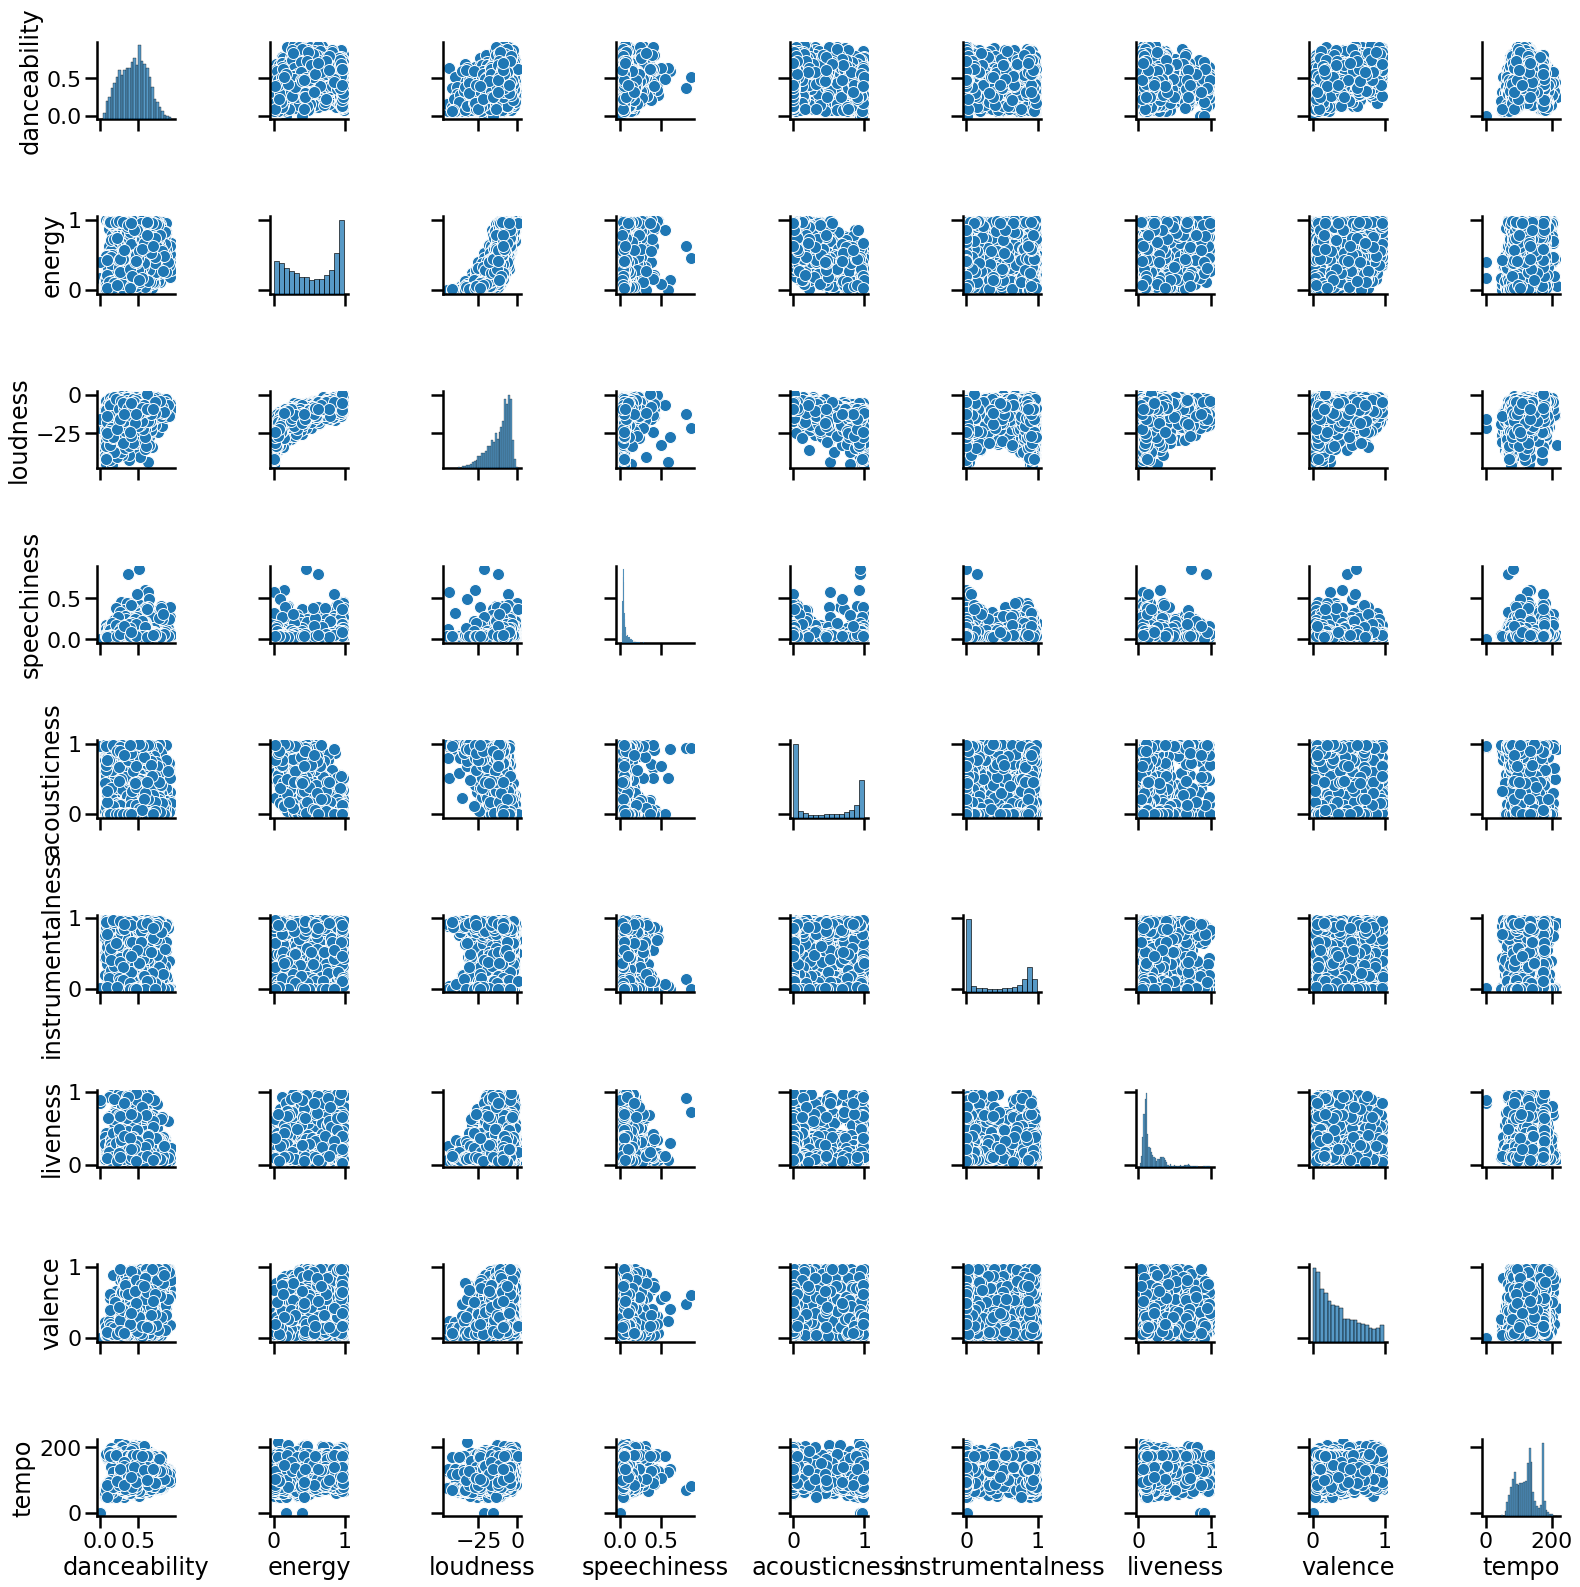

In [17]:
sns.pairplot(df_af_num);

Con el objetivo de identificar las variables más o menos informativas, vamos a analizar la correlación de las variables numéricas previamente seleccionadas.

In [18]:
df_af_num.corr()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
danceability,1.000000,0.302459,0.405870,0.019451,-0.339075,-0.193985,-0.033091,0.587137,0.205519
energy,0.302459,1.000000,0.860182,0.344713,-0.895236,-0.078853,0.175633,0.339275,0.437383
loudness,0.405870,0.860182,1.000000,0.234375,-0.767183,-0.253148,0.143914,0.374012,0.408409
speechiness,0.019451,0.344713,0.234375,1.000000,-0.289173,-0.073044,0.140281,0.058777,0.141486
acousticness,-0.339075,-0.895236,-0.767183,-0.289173,1.000000,0.043314,-0.114591,-0.289461,-0.419675
instrumentalness,-0.193985,-0.078853,-0.253148,-0.073044,0.043314,1.000000,-0.054626,-0.291403,-0.027595
liveness,-0.033091,0.175633,0.143914,0.140281,-0.114591,-0.054626,1.000000,0.008181,0.071132
valence,0.587137,0.339275,0.374012,0.058777,-0.289461,-0.291403,0.008181,1.000000,0.186940
tempo,0.205519,0.437383,0.408409,0.141486,-0.419675,-0.027595,0.071132,0.186940,1.000000


Se encontró una muy alta correlación entre las variables:
* loudness y energy: con un indice de correlación positiva de 0.860182, y por otro lado.
* acousticness y energy: tienen un indice de -0.895236, con una correlación lineal negativa muy alta.
* loudness y acousticness: tienen un indice de correlación negativa alta de -0.767183.




A continuación vamos a estandarizar las variables numéricas de manera de independizarnos de la unidades de medición utilizadas en cada caso, y poder comparar la distribución entre las mismas.


In [19]:
# estandarizamos por mix y max
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df_af_num)
df_af_scale_minmax = pd.DataFrame(scaled_df,columns=df_af_num.columns)
df_af_scale_minmax.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.638478,0.964909,0.891774,0.145858,0.002851,0.854545,0.060299,0.279188,0.801047
1,0.071564,0.057668,0.431571,0.046908,0.997992,0.572727,0.101704,0.037766,0.342310
2,0.273784,0.242044,0.647499,0.046791,0.532129,0.000003,0.054621,0.309645,0.829509
3,0.255814,0.445569,0.830552,0.037106,0.495984,0.000226,0.172948,0.088020,0.401823
4,0.741015,0.807503,0.872394,0.172695,0.183735,0.003788,0.107899,0.989848,0.685235


Una vez estandarizadas las variables, vamos a generar el gráfico de tipo scatter matrix con el datasest generado.

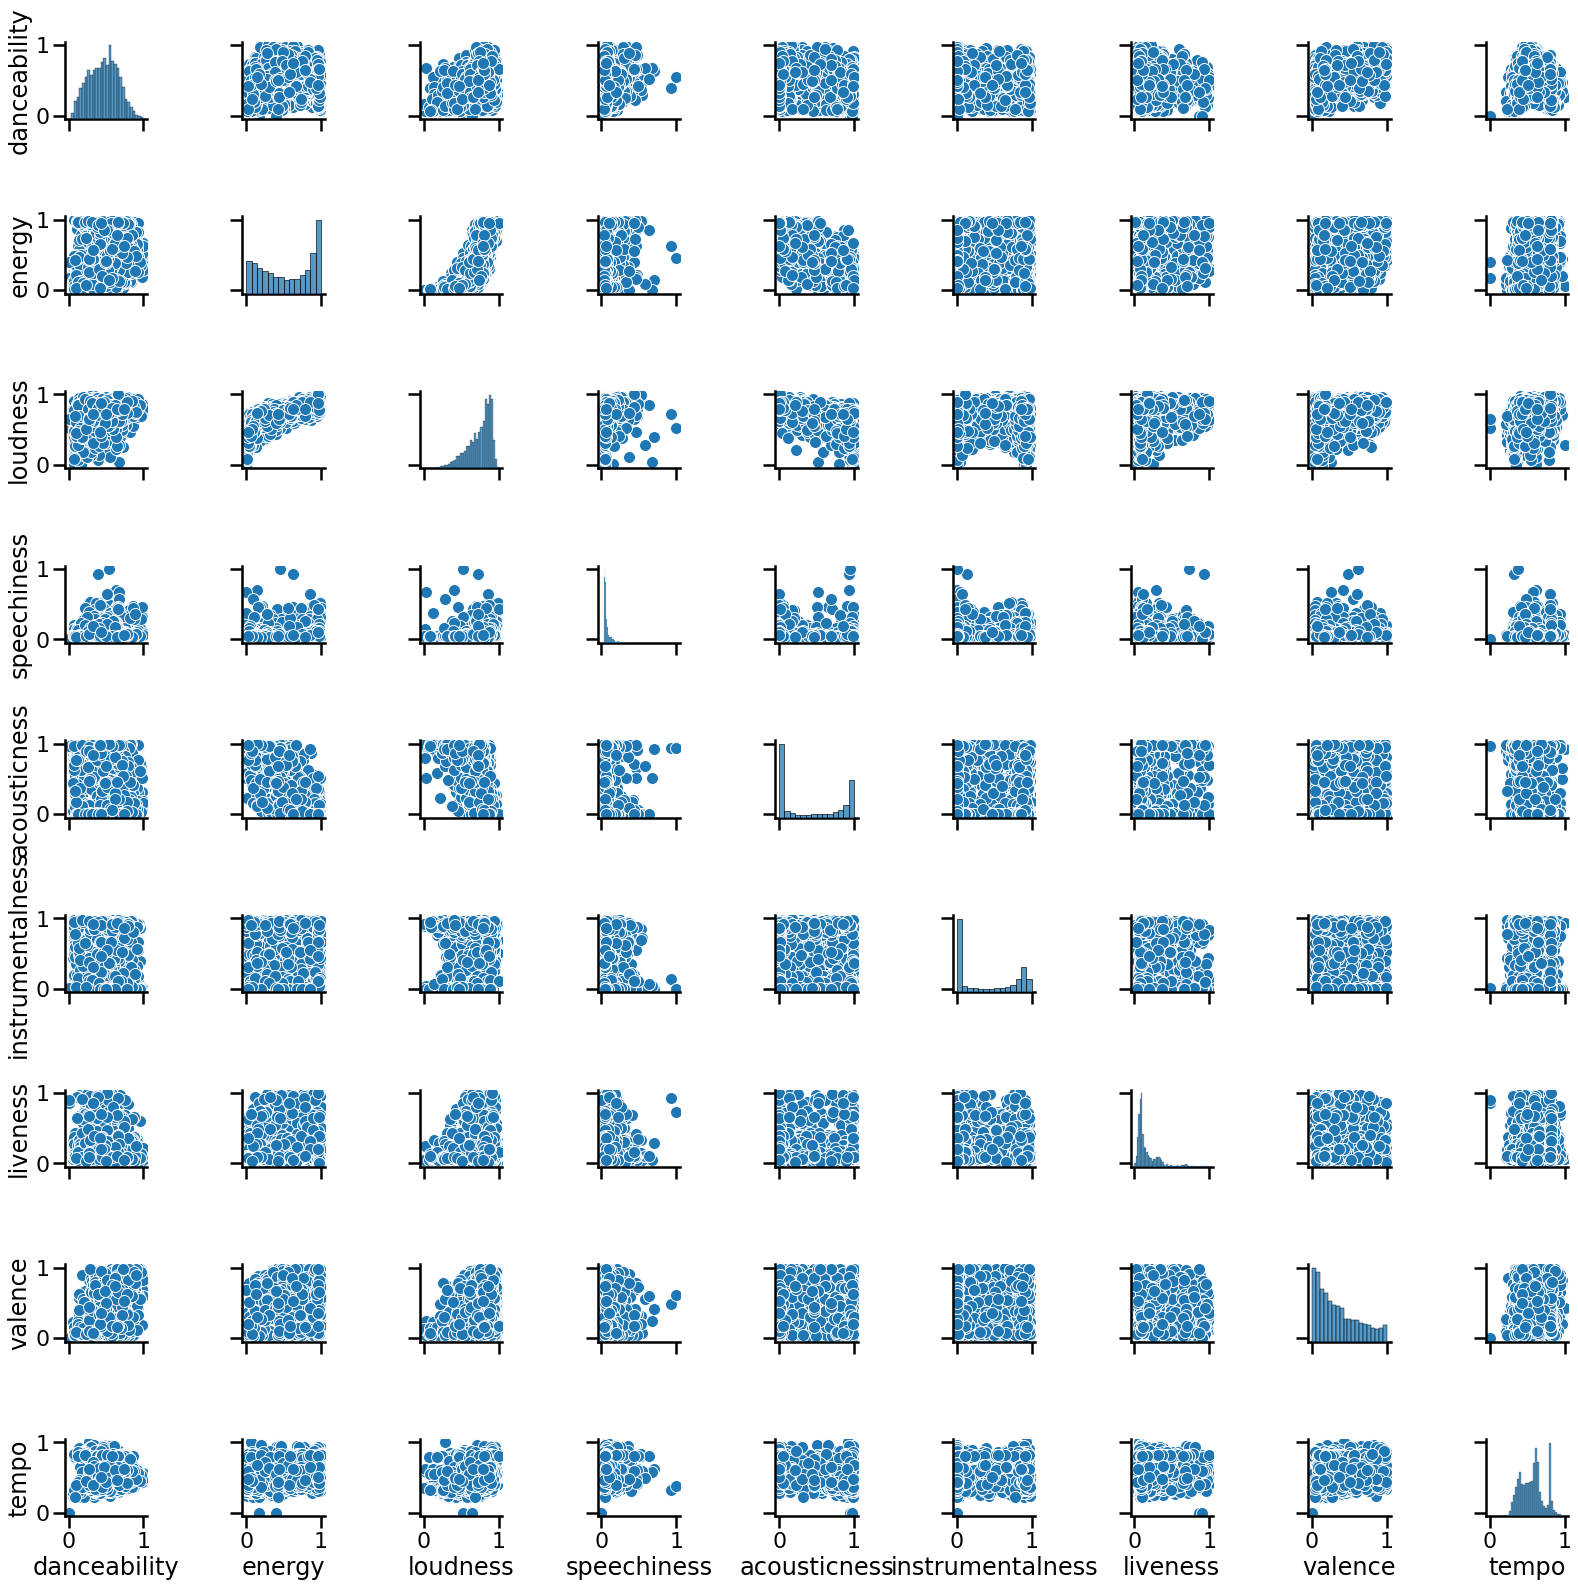

In [20]:
sns.pairplot(df_af_scale_minmax);

Se puede observar lo siguiente:

* Distribuciones con forma normal: danceability, tempo
* Distribuciones con forma logaritmica: speechiness, liveness, valence
* Distribuciones con forma exponencial: loudness
* Distribuciones con forma de U con valores entre 0 y 1: acousticness, instrumentalness y energy


Vamos a definir las siguientes funciones que serán utilizadas para realizar transformaciones sobre las variables con el objetivo de obtener una distribución normal.


In [21]:
def logit(x):
  """logit: mapea intervalo entre 0 y 1 al -infinito e infinito """
  return np.log(1/((1/x)-1))

In [22]:
def expo(x):
  return np.exp((1/x))

In [23]:
def expo2(x):
  return np.exp(np.log10(x))


* Distribuciones con forma normal: danceability y tempo


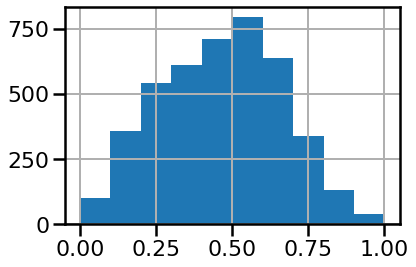

In [24]:
df_af_scale_minmax['danceability'].hist()

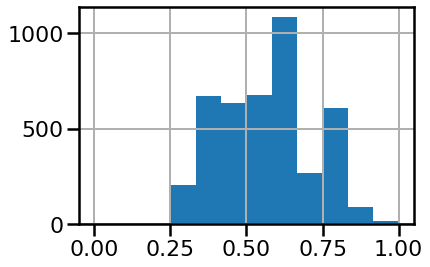

In [25]:
df_af_scale_minmax['tempo'].hist(bins=12)

La variable tempo, tiene una forma similar a la normal, a excepción de un pico de ocurrencias alrededor del valor 0.8. Por ahora, no vamos a transformar esta variable.


* Distribuciones con forma logaritmita: speechiness, liveness, valence


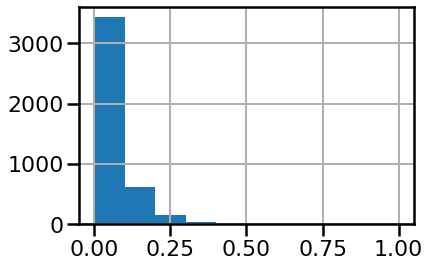

In [29]:
df_af_scale_minmax['speechiness'].hist()

Antes de aplicar la transformación logarítmica, vamos a sumar un pequeño valor para evitar aplicarlo al valor cero.


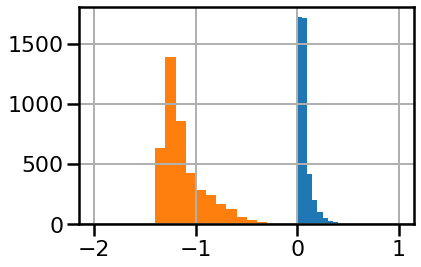

In [30]:
# transformamos al normal algunas variables
df_af_scale_minmax['speechiness'].hist(bins=20)
df_af_scale_minmax['speechiness_log']=(df_af_scale_minmax['speechiness']+0.01).apply(np.log10)
df_af_scale_minmax['speechiness_log'].hist(bins=20)

Se puede observar del lado derecho la distribucion sin transformar y a la izquierda la distribución transformada. 
Si bien se mejoró la aproximación a la normal, se observa asimétrica, con cola larga a derecha.


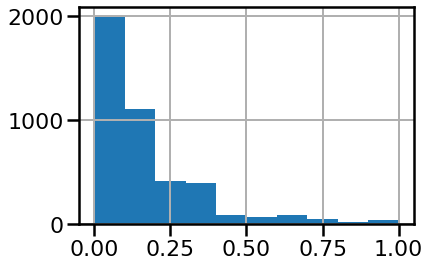

In [31]:
df_af_scale_minmax['liveness'].hist()

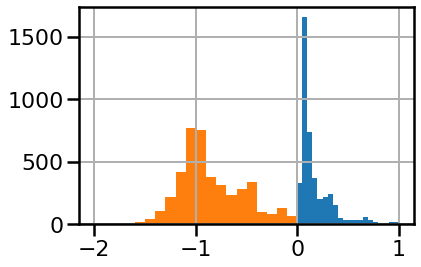

In [32]:
# transformamos al normal algunas variables
df_af_scale_minmax['liveness'].hist(bins=20)
df_af_scale_minmax['liveness_log']=(df_af_scale_minmax['liveness']+0.01).apply(np.log10)
df_af_scale_minmax['liveness_log'].hist(bins=20)

A la derecha vemos la distribución sin aplicar la transformación y a la izquierda se ve la distribución transformada bastante parecida a la normal.

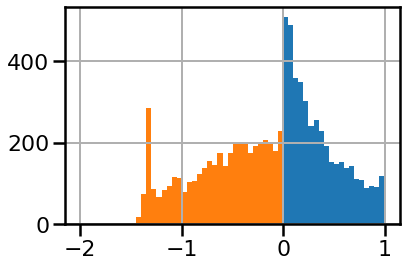

In [41]:
# transformamos al normal algunas variables
df_af_scale_minmax['valence'].hist(bins=20)
df_af_scale_minmax['valence_log']=(df_af_scale_minmax['valence']+0.01).apply(np.log10)
df_af_scale_minmax['valence_log'].hist(bins=40)


En el caso de valence, si bien se obtuvo una distribución mas aproximada a la normal, con respecto a la original, aun no se ha logrado una distribución normal tal como lo esperabamos.

A la derecha se puede apreciar la distribución sin aplicar la transformación y a la izquierda la distribución transformada.
A continuación vamos a intentar con la transformación logit para ver que sucede.

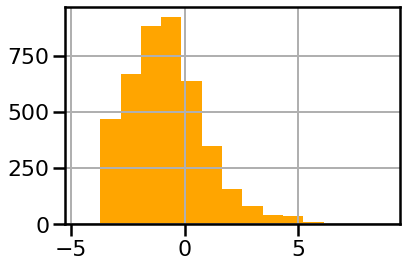

In [42]:
# transformamos al normal algunas variables
df_af_scale_minmax['valence_logit']=(df_af_scale_minmax['valence']+0.01).apply(logit)
df_af_scale_minmax['valence_logit'].hist(bins=15, color='orange')


En el caso de valence con la transformación logit, si bien no se obtuvo una distribución muy pareceda a la normal, el resultado mejoró respecto a aplicar el logaritmo. Todavia se puede observar asimetría con cola larga a derecha.

* Distribuciones con forma de U con valores entre 0 y 1: acousticness, instrumentalness.


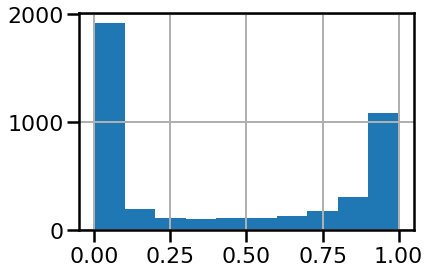

In [43]:
df_af_scale_minmax['acousticness'].hist()

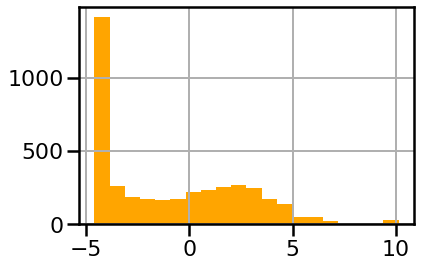

In [44]:
# transformamos al normal algunas variables
df_af_scale_minmax['acousticness_logit']=(df_af_scale_minmax['acousticness']+0.01).apply(logit)
df_af_scale_minmax['acousticness_logit'].hist(bins=20, color='orange')

La distribución obtenida luego de la transformación, logró que en lugar de tomar valores entre 0 y 1, ahora toma valores entre -5 y 10. 

Ahora bien, no se aprecia una distribucion normal, ya que tienen muchas ocurrencias para valores muy cercanos a -5, algunos outliers cerca del 10, y para el resto puede aproximar a una normal.

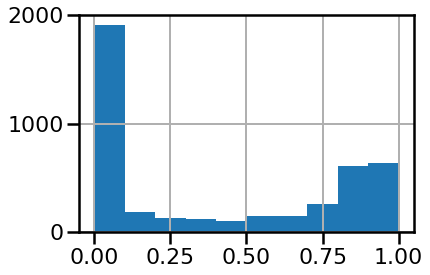

In [45]:
df_af_scale_minmax['instrumentalness'].hist()

Tal como se puede apreciar el dominio de la función, toma valores entre 0 y 1, y trataremos de transformarla para que pueda tomar valores en el intervalo real. 

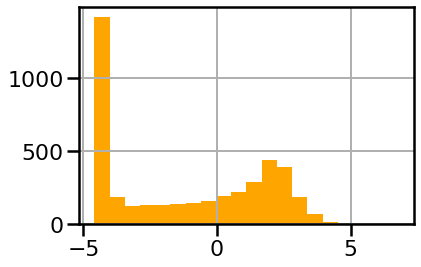

In [46]:
# transformamos al normal algunas variables
df_af_scale_minmax['instrumentalness_logit']=(df_af_scale_minmax['instrumentalness']+0.01).apply(logit)
df_af_scale_minmax['instrumentalness_logit'].hist(bins=20, color='orange')

Al igual que lo que sucede con acousticness,  en el caso de instrumentalness, si bien se distribuyeron las distribuciones. Tenemos el problema de la gran cantidad de ocurrencias para valores cercanos a -5, lo cual indica que la distribución obtenida no es normal.

 

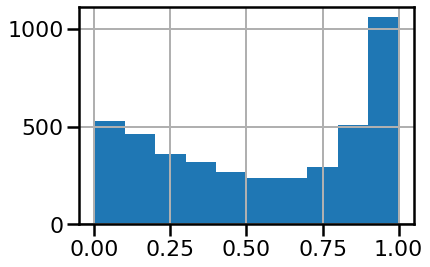

In [48]:
df_af_scale_minmax['energy'].hist()

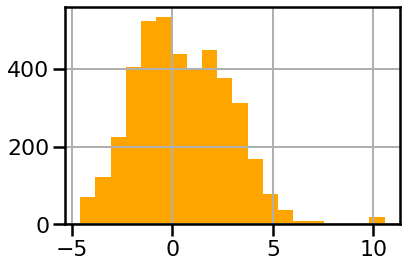

In [49]:
# transformamos al normal algunas variables
df_af_scale_minmax['energy_logit']=(df_af_scale_minmax['energy']+0.01).apply(logit)
df_af_scale_minmax['energy_logit'].hist(bins=20, color='orange')

En el caso de la variable energy, el resultado de aplicar la transformación logit, obtuvo un resultado satisfactorio.



* Distribuciones con forma exponencial: loudness


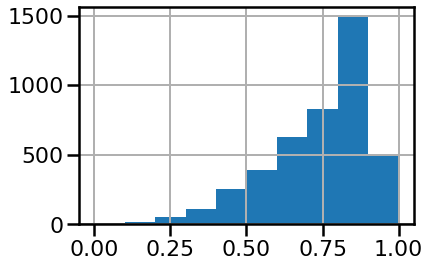

In [50]:
df_af_scale_minmax['loudness'].hist()

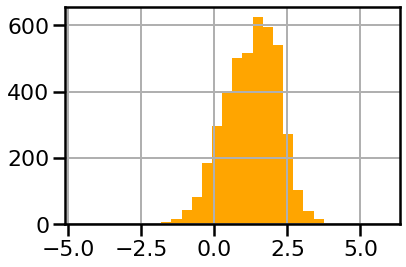

In [51]:
# transformamos al normal algunas variables
df_af_scale_minmax['loudness_logit']=(df_af_scale_minmax['loudness']+0.01).apply(logit)
df_af_scale_minmax['loudness_logit'].hist(bins=30, color='orange')

Al aplicar la transformación logit para la variable loudness, se obtuvo una distribución parecida a la normal.

Antes de continuar, podemos observar que si aplicamos la función de transformacion quantile_transform, al dataset con los datos numéricos estandarizados, obtenemos una distribución normal para todas las variables.

Si bien, con esta transformación obtenemos el resultado deseado, en principio es como una caja negra, y desconocemos la transformación específica que se aplica en cada caso.

In [52]:
from sklearn.preprocessing import quantile_transform

In [53]:
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness','liveness','valence' , 'tempo' ]
df_af_scale_minmax[features].head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.638478,0.964909,0.891774,0.145858,0.002851,0.854545,0.060299,0.279188,0.801047
1,0.071564,0.057668,0.431571,0.046908,0.997992,0.572727,0.101704,0.037766,0.342310
2,0.273784,0.242044,0.647499,0.046791,0.532129,0.000003,0.054621,0.309645,0.829509
3,0.255814,0.445569,0.830552,0.037106,0.495984,0.000226,0.172948,0.088020,0.401823
4,0.741015,0.807503,0.872394,0.172695,0.183735,0.003788,0.107899,0.989848,0.685235


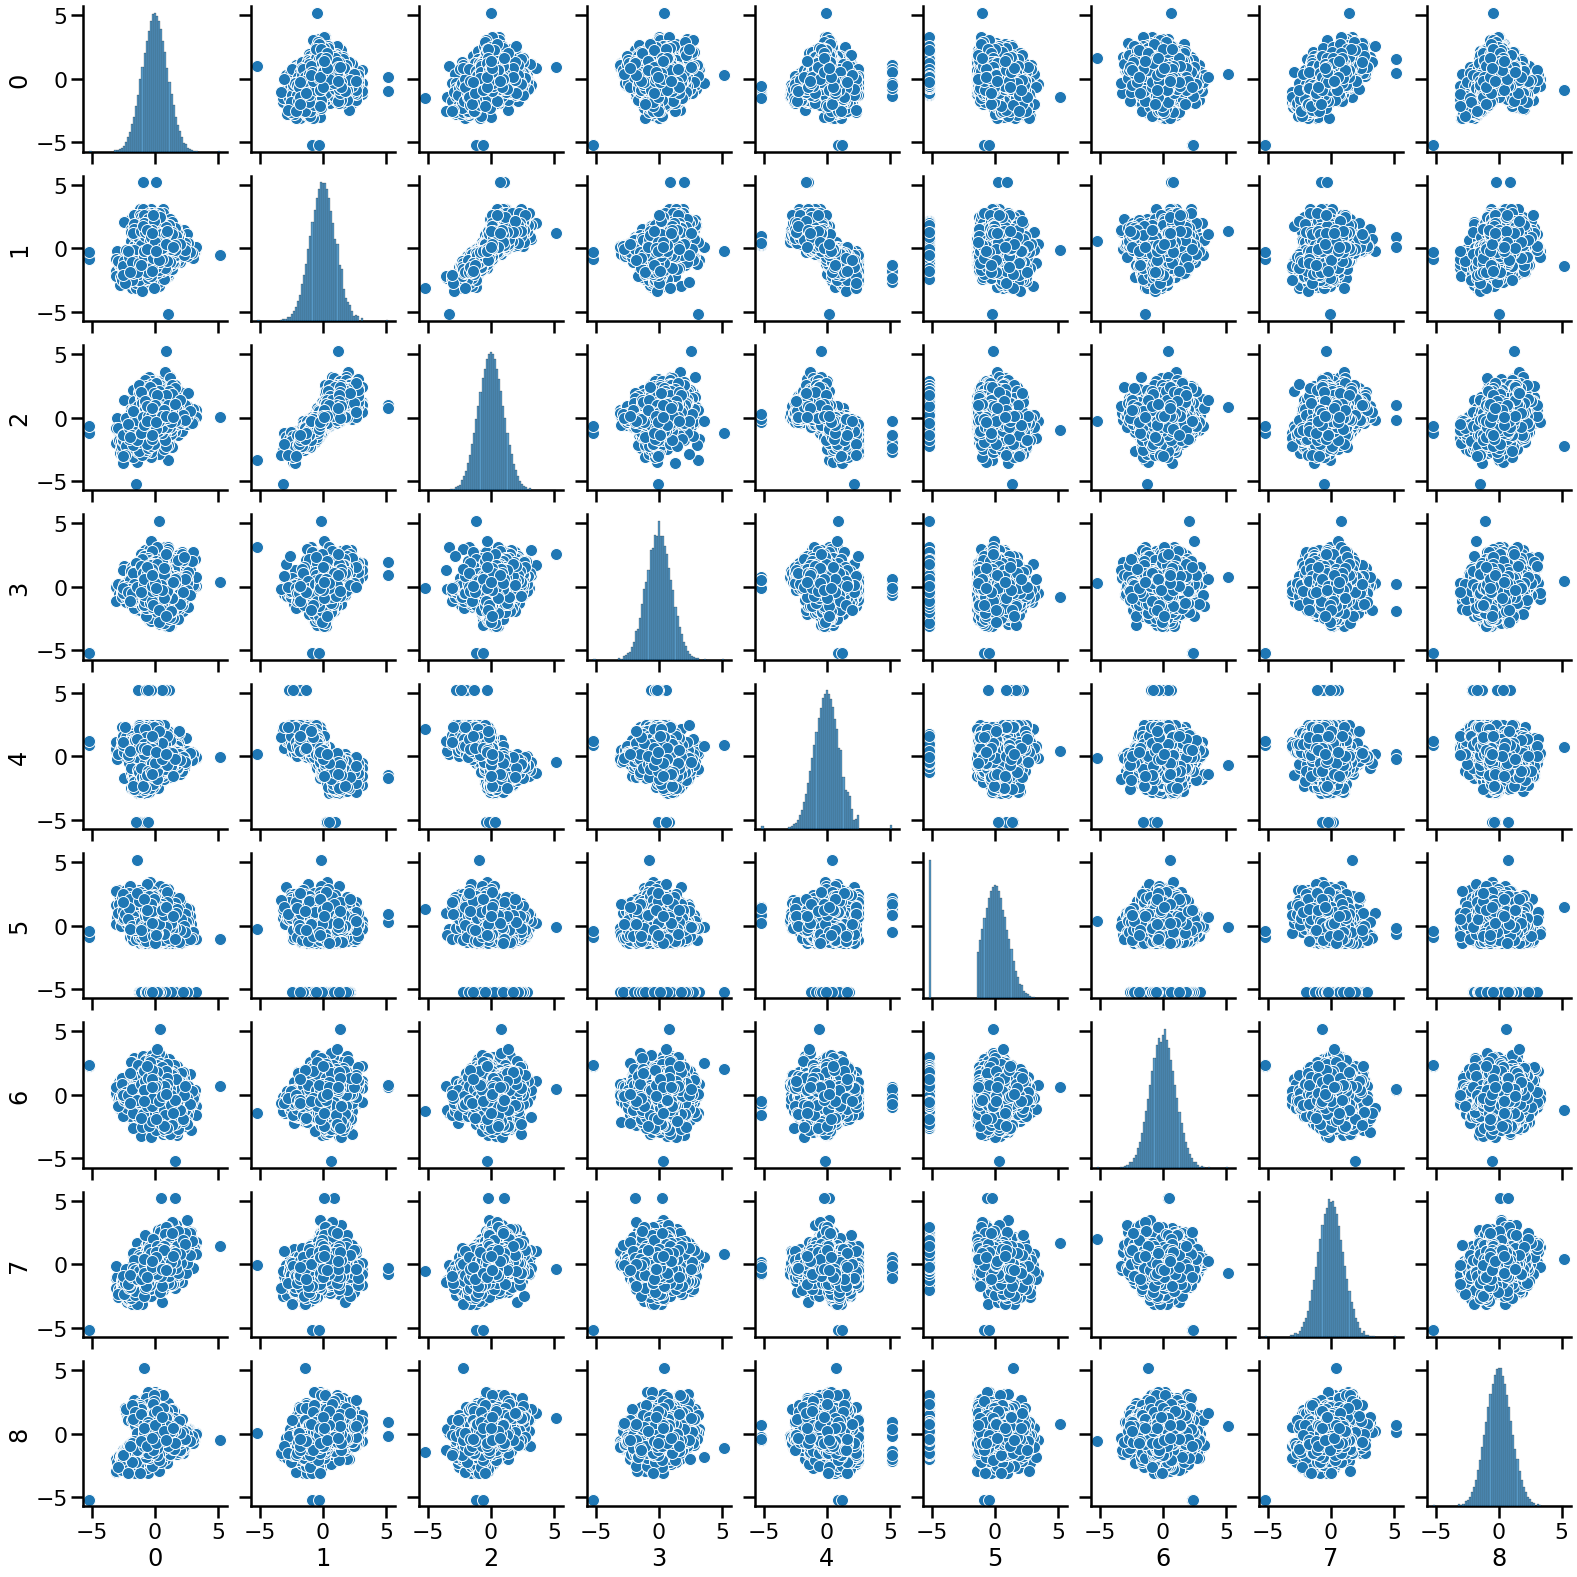

In [54]:
dist_norm =quantile_transform(df_af_scale_minmax[features].values, n_quantiles=1000, output_distribution='normal', copy=True).squeeze()
df_norm = pd.DataFrame(dist_norm)
sns.pairplot(pd.DataFrame(df_norm))

Analicemos cada una de las variables, para identificar, si es que hay, valores extremos que sea necesario descartar.


In [55]:
# outliers univariados
# df_af_scale_minmax.boxplot(fontsize=10,grid=True, figsize=(20,10))
df_af_scale_minmax.columns

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'speechiness_log',
       'tempo_log', 'liveness_log', 'valence_log', 'valence_logit',
       'acousticness_logit', 'instrumentalness_logit', 'instrumentalness_log',
       'energy_logit', 'loudness_logit'],
      dtype='object')

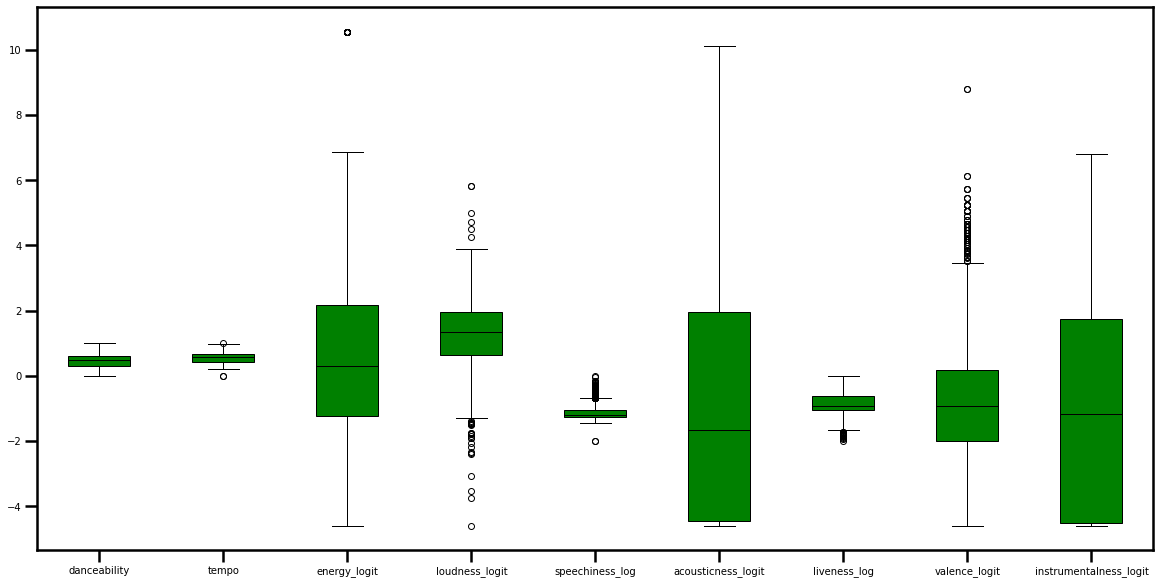

In [68]:
c='black'

df_af_scale_minmax[['danceability', 'tempo', 'energy_logit', 'loudness_logit', 
                    'speechiness_log','acousticness_logit', 'liveness_log', 'valence_logit',  
                    'instrumentalness_logit' ]].boxplot(fontsize=10, grid= False, 
                                                        figsize=(20,10),patch_artist=True,  
                                                        boxprops=dict(facecolor='green', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)

Observando el grafico anterior, vemos las variables resultantes de la transformación y su distribución a traves de boxpolot.
Con respecto a valores atípicos, notamos:

* danceability, acousticness y instrumentalness, no presentan valores atípicos.
* tempo, sólo presenta un valor atipico a izquierda y otro a derecha.
* energy, sólo un valor atípico a derecha.
* loudness, presenta gran cantidad de valores atípicos tanto a derecha como a izquierda
* speechiness, muestra un outlier a izquierda y varios a derecha.
* liveness, varios outliers a izquierda
* valence, varios outliers a derecha


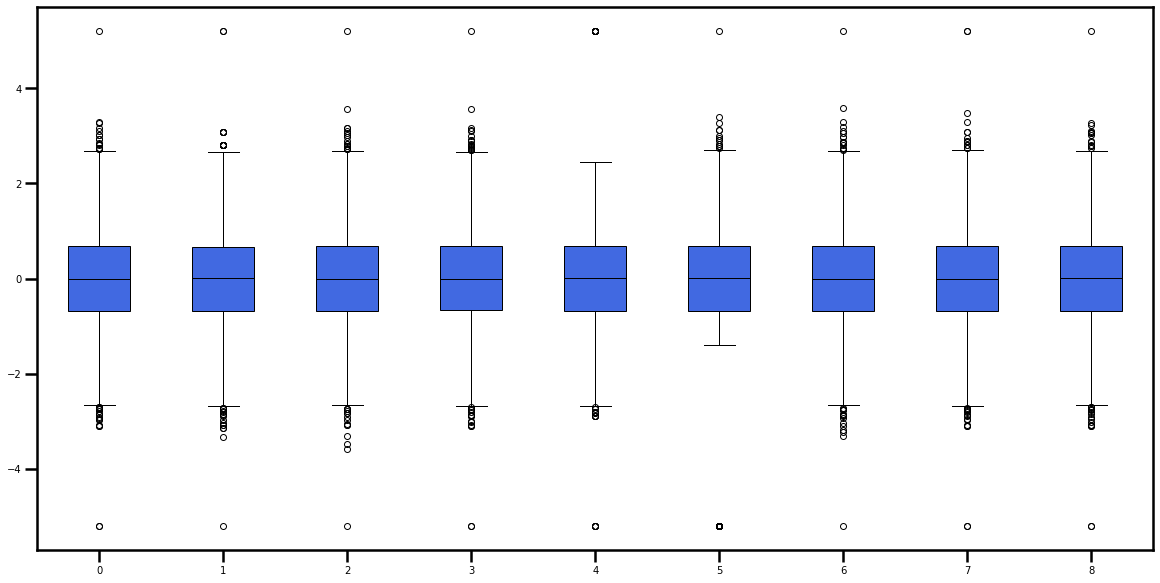

In [77]:
c='black'
#box_colors = ['darkkhaki', 'royalblue']
#facecolor=box_colors[i % 2]
df_norm.boxplot(fontsize=10, grid= False, 
                                          figsize=(20,10),patch_artist=True,  
                                                        boxprops=dict(facecolor='royalblue', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)

# Dataset *audio_analysis*

El dataset *audio_analysis* contiene las variables continuas de bajo nivel, estimadas en ventanas temporales, como *timbre* o *pitches*. Como primer paso, deberán:

-   Resumir estas variables en valores por canción. Por ejemplo, tomar el promedio o el desvío estándar del timbre entre todas las ventanas, obteniendo 12 valores de timbre promedio y 12 valores de desvío estándar del timbre por canción.

-   Contruir un *data frame* con estos valores.

-   Generar un gráfico tipo *scatter matrix*.

-   Identificar variables más o menos informativas *a priori* y variables que requieran, además de la estandarización, alguna corrección para asimilar la distribución a una normal.

-   Estandarizar y volver a generar un gráfico tipo *scatter matrix*.

-   Identificar, si es que hay, valores extremos que sea necesario descartar.

In [78]:
df_aa.head()

,start,duration,confidence,loudness_start,loudness_max_time,loudness_max,loudness_end,pitches,timbre,id
0,0.00000,0.33061,0.000,-15.742,0.01269,-12.896,0.0,"[0.102, 0.103, 0.112, 0.21, 1.0, 0.068, 0.045,...","[43.022, 16.787, -40.89, 11.82, 105.068, -67.1...",6avAsaa2IsXHT2mtQ6cGVe
1,0.33061,0.36481,0.159,-22.482,0.08965,-18.792,0.0,"[0.008, 0.022, 0.029, 0.191, 1.0, 0.078, 0.013...","[38.644, -65.426, -9.06, -7.153, 135.949, -47....",6avAsaa2IsXHT2mtQ6cGVe
2,0.69542,0.53002,1.000,-23.472,0.00965,-7.144,0.0,"[0.037, 0.047, 0.063, 0.307, 1.0, 0.149, 0.06,...","[47.643, 50.817, 75.922, 53.108, 25.988, -42.0...",6avAsaa2IsXHT2mtQ6cGVe
3,1.22544,0.44059,0.626,-19.710,0.00809,-10.394,0.0,"[0.045, 0.067, 0.048, 0.131, 0.464, 0.104, 0.0...","[44.839, -20.55, 58.387, 38.347, 47.279, -59.7...",6avAsaa2IsXHT2mtQ6cGVe
4,1.66603,0.26816,0.082,-21.887,0.11164,-18.096,0.0,"[0.022, 0.045, 0.036, 0.149, 0.695, 0.147, 0.0...","[40.058, -29.617, 61.054, -12.254, 110.751, -4...",6avAsaa2IsXHT2mtQ6cGVe


Veamos el tipo de datos que tienen cada uno de los atributos de dataframe de auido analisis.

In [79]:
df_aa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4504350 entries, 0 to 1676
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   start              float64
 1   duration           float64
 2   confidence         float64
 3   loudness_start     float64
 4   loudness_max_time  float64
 5   loudness_max       float64
 6   loudness_end       float64
 7   pitches            object 
 8   timbre             object 
 9   id                 object 
dtypes: float64(7), object(3)
memory usage: 378.0+ MB


In [80]:
df_aa.columns

Index(['start', 'duration', 'confidence', 'loudness_start',
       'loudness_max_time', 'loudness_max', 'loudness_end', 'pitches',
       'timbre', 'id'],
      dtype='object')

In [81]:
# vemos cuantos ids distintos tienen
df_aa['id'].value_counts()

4IIt36M11AQ5bHdzFQLEny    12374
4t3Yh6tKkxXrc458pNI7zZ     9519
0Ne5itrohiBOTy425hrBGJ     5622
7q85l1IotccRFlv3GgsvEU     5517
3kXJcMyhICI8U85Ce0WAED     5384
                          ...  
032rrZGB7Dr0YAcdgG31vV       97
0nNiyH4NViNdsL0JJz5yce       93
7DhJg9jCPljVOmUTXQ7dCy       73
0wvbb2MxlokwqSvbeoOOHv       65
6yYV3V3jqeWXinATQmngVc       57
Name: id, Length: 4177, dtype: int64

In [82]:
a=df_aa[df_aa['id']=='00At7PWydsvg7g5xgaYan9']['timbre'].apply(pd.Series)
#a[0].mean()
a

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000,171.130,9.469,-28.480,57.491,-50.067,14.833,5.359,-27.228,0.973,-10.640,-7.228
1,37.641,-77.643,-30.613,137.462,36.960,-51.024,-18.745,-28.822,-7.170,-1.994,-15.695,9.411
2,38.171,-17.741,-22.798,149.223,31.833,-53.446,-36.485,-39.479,-25.795,-1.903,-21.908,15.934
3,38.355,38.741,9.159,164.086,33.475,-83.620,-51.036,-23.505,-19.636,8.674,-18.950,6.718
4,40.292,38.220,-50.706,130.054,-4.597,-82.764,-32.596,-48.432,-21.086,20.443,-27.538,25.327
...,...,...,...,...,...,...,...,...,...,...,...,...
886,56.824,169.002,50.893,-4.497,77.509,-6.280,-31.490,-3.827,-8.619,-1.390,-22.228,-9.742
887,56.501,125.219,92.821,-10.895,123.496,-34.915,12.665,-13.193,-5.209,14.087,-17.509,-22.331
888,56.087,120.727,85.559,53.613,104.176,-42.061,-13.753,11.311,-21.318,-11.279,-21.996,7.502
889,57.070,126.266,65.693,20.776,80.150,-24.147,19.913,25.135,-0.312,1.195,8.402,-1.765


In [83]:
b=df_aa[df_aa['id']=='00At7PWydsvg7g5xgaYan9']
b

,start,duration,confidence,loudness_start,loudness_max_time,loudness_max,loudness_end,pitches,timbre,id
0,0.00000,0.24381,0.000,-60.000,0.00000,-60.000,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ...",00At7PWydsvg7g5xgaYan9
1,0.24381,0.17492,1.000,-60.000,0.01436,-12.457,0.0,"[0.121, 0.996, 0.08, 0.104, 1.0, 0.223, 0.043,...","[37.641, -77.643, -30.613, 137.462, 36.96, -51...",00At7PWydsvg7g5xgaYan9
2,0.41873,0.17329,1.000,-34.279,0.01554,-12.728,0.0,"[0.032, 1.0, 0.06, 0.059, 0.368, 0.084, 0.036,...","[38.171, -17.741, -22.798, 149.223, 31.833, -5...",00At7PWydsvg7g5xgaYan9
3,0.59202,0.17351,1.000,-32.474,0.01059,-10.984,0.0,"[0.286, 1.0, 0.237, 0.277, 0.694, 0.332, 0.155...","[38.355, 38.741, 9.159, 164.086, 33.475, -83.6...",00At7PWydsvg7g5xgaYan9
4,0.76553,0.17569,1.000,-32.786,0.01254,-9.480,0.0,"[0.064, 0.878, 0.028, 0.129, 1.0, 0.181, 0.068...","[40.292, 38.22, -50.706, 130.054, -4.597, -82....",00At7PWydsvg7g5xgaYan9
...,...,...,...,...,...,...,...,...,...,...
886,192.48766,0.15664,0.616,-7.482,0.05342,0.167,0.0,"[0.479, 1.0, 0.531, 0.371, 0.554, 0.563, 0.547...","[56.824, 169.002, 50.893, -4.497, 77.509, -6.2...",00At7PWydsvg7g5xgaYan9
887,192.64432,0.22630,0.369,-5.934,0.10005,-1.894,0.0,"[0.188, 1.0, 0.186, 0.154, 0.086, 0.181, 0.148...","[56.501, 125.219, 92.821, -10.895, 123.496, -3...",00At7PWydsvg7g5xgaYan9
888,192.87060,0.11628,0.026,-3.299,0.01735,-1.597,0.0,"[0.446, 1.0, 0.252, 0.185, 0.63, 0.58, 0.582, ...","[56.087, 120.727, 85.559, 53.613, 104.176, -42...",00At7PWydsvg7g5xgaYan9
889,192.98690,0.34254,0.730,-8.405,0.03680,0.489,0.0,"[0.215, 0.252, 0.202, 0.208, 0.16, 0.232, 0.86...","[57.07, 126.266, 65.693, 20.776, 80.15, -24.14...",00At7PWydsvg7g5xgaYan9


In [84]:
df_aa.shape

(4504350, 10)

In [85]:
gp = df_aa.groupby('id')
gp.first()

,start,duration,confidence,loudness_start,loudness_max_time,loudness_max,loudness_end,pitches,timbre
id,,,,,,,,,
00At7PWydsvg7g5xgaYan9,0.0,0.24381,0.000,-60.000,0.00000,-60.000,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."
00BgcUYkIImsDN5rNjkR1U,0.0,0.16980,0.000,-17.313,0.01272,-14.302,0.0,"[0.152, 1.0, 0.339, 0.073, 0.107, 0.17, 0.055,...","[39.206, 168.479, -97.004, 66.837, 91.935, -59..."
00WgnFIsY1y84p7mYAJRuF,0.0,0.16816,0.000,-60.000,0.00000,-60.000,0.0,"[1.0, 0.776, 0.467, 0.338, 0.442, 0.453, 0.671...","[0.134, 170.681, 11.306, -32.086, 57.232, -51...."
00X2ieWUjpzdNwDU2Jlg6i,0.0,0.22054,0.000,-60.000,0.00000,-60.000,0.0,"[1.0, 0.739, 0.226, 0.295, 0.436, 0.529, 0.392...","[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."
00isAURAZeKQXv6CW2vckb,0.0,0.57723,0.161,-60.000,0.55147,-55.255,0.0,"[0.552, 0.501, 0.46, 0.324, 0.116, 0.401, 0.42...","[1.48, 137.847, -22.243, -63.484, 41.726, -45...."
...,...,...,...,...,...,...,...,...,...
7zKweXON2KcgXizqUcu7lf,0.0,0.82426,1.000,-60.000,0.09948,-5.703,0.0,"[0.066, 0.189, 1.0, 0.065, 0.044, 0.04, 0.038,...","[28.992, 158.807, 115.118, -396.881, -9.121, 1..."
7zbRQboW74uyd6gp4zxZx0,0.0,0.24141,1.000,-52.842,0.07008,-10.582,0.0,"[0.936, 1.0, 0.491, 0.387, 0.406, 0.373, 0.255...","[22.317, 95.959, 42.215, -161.623, 15.791, 124..."
7zjWtWDCNgeXSY78nLzBQJ,0.0,0.38921,0.000,-60.000,0.00000,-60.000,0.0,"[1.0, 0.967, 0.799, 0.618, 0.486, 0.381, 0.518...","[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."


In [86]:
gp.count()
# tienen que haber 4177 grupos en total

,start,duration,confidence,loudness_start,loudness_max_time,loudness_max,loudness_end,pitches,timbre
id,,,,,,,,,
00At7PWydsvg7g5xgaYan9,891,891,891,891,891,891,891,891,891
00BgcUYkIImsDN5rNjkR1U,993,993,993,993,993,993,993,993,993
00WgnFIsY1y84p7mYAJRuF,1476,1476,1476,1476,1476,1476,1476,1476,1476
00X2ieWUjpzdNwDU2Jlg6i,581,581,581,581,581,581,581,581,581
00isAURAZeKQXv6CW2vckb,815,815,815,815,815,815,815,815,815
...,...,...,...,...,...,...,...,...,...
7zKweXON2KcgXizqUcu7lf,822,822,822,822,822,822,822,822,822
7zbRQboW74uyd6gp4zxZx0,649,649,649,649,649,649,649,649,649
7zjWtWDCNgeXSY78nLzBQJ,680,680,680,680,680,680,680,680,680


In [91]:
#armo las variables que va a tener mi dataframe final
lista_col=[]
# agrego el id
lista_col.append('id')
# agrego las medias y el desvio estandar de los picth por columna
lista_col.extend(list('mean_pitch' + str(i) for i in range(12) ))
lista_col.extend(list('sd_pitch' + str(i) for i in range(12) ))
#agrego las medias y el desvio estandar de los timbres por columna
lista_col.extend(list('mean_timbre' + str(i) for i in range(12) ))
lista_col.extend(list('sd_timbre' + str(i) for i in range(12) ))
df_aux= pd.DataFrame(columns=lista_col)


In [92]:
# estructura que va a tener el dataframe de df_aa resumido
df_aux.columns

Index(['id', 'mean_pitch0', 'mean_pitch1', 'mean_pitch2', 'mean_pitch3',
       'mean_pitch4', 'mean_pitch5', 'mean_pitch6', 'mean_pitch7',
       'mean_pitch8', 'mean_pitch9', 'mean_pitch10', 'mean_pitch11',
       'sd_pitch0', 'sd_pitch1', 'sd_pitch2', 'sd_pitch3', 'sd_pitch4',
       'sd_pitch5', 'sd_pitch6', 'sd_pitch7', 'sd_pitch8', 'sd_pitch9',
       'sd_pitch10', 'sd_pitch11', 'mean_timbre0', 'mean_timbre1',
       'mean_timbre2', 'mean_timbre3', 'mean_timbre4', 'mean_timbre5',
       'mean_timbre6', 'mean_timbre7', 'mean_timbre8', 'mean_timbre9',
       'mean_timbre10', 'mean_timbre11', 'sd_timbre0', 'sd_timbre1',
       'sd_timbre2', 'sd_timbre3', 'sd_timbre4', 'sd_timbre5', 'sd_timbre6',
       'sd_timbre7', 'sd_timbre8', 'sd_timbre9', 'sd_timbre10', 'sd_timbre11'],
      dtype='object')

In [93]:
df_aux.head()

,id,mean_pitch0,mean_pitch1,mean_pitch2,mean_pitch3,mean_pitch4,mean_pitch5,mean_pitch6,mean_pitch7,mean_pitch8,mean_pitch9,mean_pitch10,mean_pitch11,sd_pitch0,sd_pitch1,sd_pitch2,sd_pitch3,sd_pitch4,sd_pitch5,sd_pitch6,sd_pitch7,sd_pitch8,sd_pitch9,sd_pitch10,sd_pitch11,mean_timbre0,mean_timbre1,mean_timbre2,mean_timbre3,mean_timbre4,mean_timbre5,mean_timbre6,mean_timbre7,mean_timbre8,mean_timbre9,mean_timbre10,mean_timbre11,sd_timbre0,sd_timbre1,sd_timbre2,sd_timbre3,sd_timbre4,sd_timbre5,sd_timbre6,sd_timbre7,sd_timbre8,sd_timbre9,sd_timbre10,sd_timbre11


In [ ]:
# OJO en vez de correr el proceso de abajo,
# podemos levantar el dataframe de un arhcivo pickle que generé con la info, porque sino el proceso tarda 40 min
# para levantarlo primero hay que subir el archivo df_aa_final.p a memoria con la 'carga de archivos al almacenamiento de la sesion'
# y luego correr este codigo
import pickle
df_aux = pickle.load( open( "df_aa_final.p", "rb" ) )
print(df_aux.shape)
df_aux.head(10)

In [94]:
rows_df=[]
i=0
for fila_id, grupo in gp:
  i=i+1

  # aplico series a los pitch y timbres para poder trabajarlos despues
  tmp_pitch=grupo['pitches'].apply(pd.Series)
  tmp_timbre=grupo['timbre'].apply(pd.Series)
 
  # aplico media y desvio estandar al pitch
  pit1= tmp_pitch.apply(np.mean, axis=0)
  pit2= tmp_pitch.apply(np.std, axis=0)

  # aplico media y desvio estandar al timbre
  tim1= tmp_timbre.apply(np.mean, axis=0)
  tim2= tmp_timbre.apply(np.std, axis=0)

  # armo una fila para insertar en un dataframe
  lista_fila=[]
  lista_fila.append(fila_id) # id del track
  
  lista_fila.extend(pit1) # agrego medias de pitch
  lista_fila.extend(pit2) # agrego desvio standard de pitch
  lista_fila.extend(tim1) # agrego medias de timbre
  lista_fila.extend(tim2) # agrego desvío standard de timbre

 #agregamos la fila al dataframe
  rows_df.append(lista_fila)
  print(i, fila_id)


1 00At7PWydsvg7g5xgaYan9
2 00BgcUYkIImsDN5rNjkR1U
3 00WgnFIsY1y84p7mYAJRuF
4 00X2ieWUjpzdNwDU2Jlg6i
5 00isAURAZeKQXv6CW2vckb
6 00kO4Z0mFAFs6KLlXnaD0f
7 00nhkvorbdardFjuIi2OOo
8 00r6WtlzQELtNFjSfgQJas
9 01IEMsoSrK1WXJeuumBZX1
10 01K7WtcFrsolt07wYU8zTY
11 01MfWbgLTyyo0AIJ7sOeGy
12 01OXa5tVuCssU6j8TY7kxr
13 01cGujYWGF7JchJLSgf6Ta
14 01cY7Cc7t5zPB64uj8NGxz
15 01fpOKPgxIZripAqfM5zKd
16 01lhBjdfaTPsk9TKv0GGhp
17 029hlK8uy2JkLmjPV3wKN4
18 02ARurN3YINKqNGod37rt7
19 02Ldz6s7reMiMFThegV6Gu
20 02M2OoPaKPmkCl7kidq6nK
21 02PZzvMoGa2Jh6zh2des0v
22 02TadnJNMcVjr4baY39H1p
23 02cksNRxnzaM3lPk8zCuJO
24 02q6duD2HpNWJyDcgobAGQ
25 02yBnHZqIhYlnEhM3VLt7N
26 032rrZGB7Dr0YAcdgG31vV
27 03EuhmMsEHVFI9ytainStU
28 03HHqgSu89fgu6RFco0pit
29 03HwmxQ8w8gH1qU6BlmDrK
30 03LNtELU3mftqFQw8qYqrW
31 03pULHXZB4klVSLJsHh7h4
32 03vz24AIk3oIhCJBMrL4oM
33 03y0FwuuWSr0ReguaS0UBk
34 041O2IXtZ3Vdp555qyWP0W
35 0488kXJ1YnLMrrM1ssJnev
36 048AbE9LVZn2qc4mKxoEO9
37 04H0PtxuUqv8XYfaYVJGXs
38 04KAe25uribQjnSFJb8grm
39 04ZbcIONrJTCECTaYr

In [95]:
# terminamos de construir el datafram con la lista generadas
df_aux= pd.DataFrame(rows_df, columns=df_aux.columns)
df_aux.head()

,id,mean_pitch0,mean_pitch1,mean_pitch2,mean_pitch3,mean_pitch4,mean_pitch5,mean_pitch6,mean_pitch7,mean_pitch8,mean_pitch9,mean_pitch10,mean_pitch11,sd_pitch0,sd_pitch1,sd_pitch2,sd_pitch3,sd_pitch4,sd_pitch5,sd_pitch6,sd_pitch7,sd_pitch8,sd_pitch9,sd_pitch10,sd_pitch11,mean_timbre0,mean_timbre1,mean_timbre2,mean_timbre3,mean_timbre4,mean_timbre5,mean_timbre6,mean_timbre7,mean_timbre8,mean_timbre9,mean_timbre10,mean_timbre11,sd_timbre0,sd_timbre1,sd_timbre2,sd_timbre3,sd_timbre4,sd_timbre5,sd_timbre6,sd_timbre7,sd_timbre8,sd_timbre9,sd_timbre10,sd_timbre11
0,00At7PWydsvg7g5xgaYan9,0.372569,0.746600,0.288627,0.284531,0.279819,0.236079,0.303173,0.201448,0.372319,0.301180,0.289792,0.359101,0.278956,0.315104,0.226868,0.253471,0.269877,0.199185,0.258735,0.165056,0.272395,0.287251,0.291443,0.331024,54.798519,92.125193,35.913975,10.421557,49.833244,-32.670363,-2.777832,2.606419,-9.264416,6.457682,-9.620706,-2.132956,4.674393,36.152818,34.818777,34.868692,22.648563,24.314960,20.297972,18.424270,10.011592,12.286741,13.713586,11.749847
1,00BgcUYkIImsDN5rNjkR1U,0.255472,0.541902,0.147708,0.166854,0.286158,0.203731,0.405298,0.274106,0.499877,0.431839,0.294035,0.248160,0.236392,0.359939,0.157851,0.196883,0.315883,0.246249,0.351575,0.279845,0.353744,0.374848,0.264350,0.311768,53.810573,69.248870,-9.116627,-2.226798,37.537226,-42.652424,-0.684193,0.007623,-18.336879,0.615241,-8.178492,0.191112,5.365959,55.877179,38.559254,25.916739,30.750508,23.928167,21.883599,17.506083,15.533927,11.816519,15.302504,14.891460
2,00WgnFIsY1y84p7mYAJRuF,0.523316,0.378992,0.397866,0.515072,0.347002,0.338027,0.390105,0.584353,0.381764,0.325904,0.380690,0.252339,0.332723,0.302039,0.318739,0.353730,0.295090,0.294651,0.333636,0.349309,0.334210,0.310835,0.288197,0.249313,46.722248,50.900079,20.885997,15.719031,24.207190,-44.094831,14.521768,-0.068259,-20.861919,-2.182608,-3.503888,7.259081,8.478241,47.652920,70.874181,32.435488,37.451918,27.892557,26.128323,17.655452,15.848282,14.292686,14.665808,12.909679
3,00X2ieWUjpzdNwDU2Jlg6i,0.581520,0.582778,0.577449,0.349222,0.466081,0.296460,0.328719,0.459585,0.311110,0.403668,0.270599,0.347269,0.310101,0.301258,0.319801,0.210262,0.294603,0.216237,0.225375,0.308820,0.211838,0.284648,0.197873,0.247592,53.671623,51.902315,25.730107,-6.630838,10.632714,-27.621208,2.684391,5.400754,-3.055616,3.816508,-9.059971,-4.516873,3.414029,27.517160,24.974858,26.802161,18.629612,20.293563,16.982543,16.565502,13.537856,12.743424,12.529051,11.014681
4,00isAURAZeKQXv6CW2vckb,0.369134,0.536951,0.241599,0.378852,0.203259,0.335072,0.269961,0.249492,0.363373,0.204854,0.318196,0.155667,0.291137,0.348170,0.228895,0.356002,0.213297,0.324892,0.283743,0.248350,0.317578,0.212848,0.309932,0.178639,34.875225,-66.512445,40.915563,-10.102723,35.649973,-27.347364,-1.774950,0.008791,6.631508,-1.892666,-7.973755,-7.399080,6.857121,58.377532,35.071890,33.394240,27.040419,15.184624,38.374879,17.411062,23.760569,12.982456,13.483734,20.114356


In [104]:
# grabo archivo pickle
#import pickle
#pickle.dump(df_aux, open("/content/df_aa_final.p", "wb" ))


In [96]:
# verificamos que el tamaño debe ser el mismo que la cantidad de grupos que teniamos
df_aux.shape

(4177, 49)

In [102]:
#sns.pairplot(df_aux)
# hacer pairplot agrupados por pitch y timbre ? o ver distintas agrupaciones?
# no pude hacer correr el codigo de abajo, se queda colgado, lo deje mas de 15 min y lo corté
sns.pairplot(df_aux[['mean_pitch0', 'mean_pitch1', 'mean_pitch2', 'mean_pitch3', 
                    'mean_pitch4','mean_pitch5', 'mean_pitch6', 'mean_pitch7',  
                    'mean_pitch8','mean_pitch9','mean_pitch10','mean_pitch11' ]])


KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fae8c214620> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7fae8b101b70> (for post_execute):


KeyboardInterrupt: ignored

Hacemos el join final de todos los dataframes


In [ ]:
df_tot=pd.merge(df_aux, df_tracks2, on='id', how='inner')
df_tot.head()


,id,mean_pitch0,mean_pitch1,mean_pitch2,mean_pitch3,mean_pitch4,mean_pitch5,mean_pitch6,mean_pitch7,mean_pitch8,mean_pitch9,mean_pitch10,mean_pitch11,sd_pitch0,sd_pitch1,sd_pitch2,sd_pitch3,sd_pitch4,sd_pitch5,sd_pitch6,sd_pitch7,sd_pitch8,sd_pitch9,sd_pitch10,sd_pitch11,mean_timbre0,mean_timbre1,mean_timbre2,mean_timbre3,mean_timbre4,mean_timbre5,mean_timbre6,mean_timbre7,mean_timbre8,mean_timbre9,mean_timbre10,mean_timbre11,sd_timbre0,sd_timbre1,sd_timbre2,sd_timbre3,sd_timbre4,sd_timbre5,sd_timbre6,sd_timbre7,sd_timbre8,sd_timbre9,sd_timbre10,sd_timbre11,mean_start,sd_start,mean_duration,sd_duration,mean_confidence,sd_confidence,mean_loudness_start,sd_loudness_start,mean_loudness_max_time,sd_loudness_max_time,mean_loudness_max,sd_loudness_max,mean_loudness_end,sd_loudness_end,artists,album,genre,release_date,album_name
0,00At7PWydsvg7g5xgaYan9,0.372569,0.746600,0.288627,0.284531,0.279819,0.236079,0.303173,0.201448,0.372319,0.301180,0.289792,0.359101,0.278956,0.315104,0.226868,0.253471,0.269877,0.199185,0.258735,0.165056,0.272395,0.287251,0.291443,0.331024,54.798519,92.125193,35.913975,10.421557,49.833244,-32.670363,-2.777832,2.606419,-9.264416,6.457682,-9.620706,-2.132956,4.674393,36.152818,34.818777,34.868692,22.648563,24.314960,20.297972,18.424270,10.011592,12.286741,13.713586,11.749847,94.307014,56.427615,0.219921,0.117153,0.523191,0.253678,-9.056660,6.145573,0.042637,0.036067,-2.085701,3.539792,-0.067340,2.010076,Matrix & Futurebound,"{'album_type': 'ALBUM', 'artists': [{'external...",drum-and-bass,2012,All I Know EP (feat. Luke Bingham)
1,00BgcUYkIImsDN5rNjkR1U,0.255472,0.541902,0.147708,0.166854,0.286158,0.203731,0.405298,0.274106,0.499877,0.431839,0.294035,0.248160,0.236392,0.359939,0.157851,0.196883,0.315883,0.246249,0.351575,0.279845,0.353744,0.374848,0.264350,0.311768,53.810573,69.248870,-9.116627,-2.226798,37.537226,-42.652424,-0.684193,0.007623,-18.336879,0.615241,-8.178492,0.191112,5.365959,55.877179,38.559254,25.916739,30.750508,23.928167,21.883599,17.506083,15.533927,11.816519,15.302504,14.891460,121.756379,74.271403,0.257920,0.176402,0.470216,0.287486,-9.788445,6.821286,0.033210,0.045866,-3.185968,4.992566,-0.052149,1.643316,Maduk,"{'album_type': 'ALBUM', 'artists': [{'external...",drum-and-bass,2013,Feel Good
2,00WgnFIsY1y84p7mYAJRuF,0.523316,0.378992,0.397866,0.515072,0.347002,0.338027,0.390105,0.584353,0.381764,0.325904,0.380690,0.252339,0.332723,0.302039,0.318739,0.353730,0.295090,0.294651,0.333636,0.349309,0.334210,0.310835,0.288197,0.249313,46.722248,50.900079,20.885997,15.719031,24.207190,-44.094831,14.521768,-0.068259,-20.861919,-2.182608,-3.503888,7.259081,8.478241,47.652920,70.874181,32.435488,37.451918,27.892557,26.128323,17.655452,15.848282,14.292686,14.665808,12.909679,166.738426,97.014628,0.225958,0.145290,0.452725,0.287122,-17.176795,8.734792,0.033198,0.045160,-9.595632,8.701703,-0.040650,1.561738,Apex,"{'album_type': 'ALBUM', 'artists': [{'external...",drum-and-bass,2012,Omega Point EP
3,00X2ieWUjpzdNwDU2Jlg6i,0.581520,0.582778,0.577449,0.349222,0.466081,0.296460,0.328719,0.459585,0.311110,0.403668,0.270599,0.347269,0.310101,0.301258,0.319801,0.210262,0.294603,0.216237,0.225375,0.308820,0.211838,0.284648,0.197873,0.247592,53.671623,51.902315,25.730107,-6.630838,10.632714,-27.621208,2.684391,5.400754,-3.055616,3.816508,-9.059971,-4.516873,3.414029,27.517160,24.974858,26.802161,18.629612,20.293563,16.982543,16.565502,13.537856,12.743424,12.529051,11.014681,80.935954,46.300172,0.289753,0.275169,0.434289,0.236817,-9.242177,4.446102,0.052669,0.046162,-3.717814,3.196698,-0.103114,2.485444,The Mighty Mighty Bosstones,"{'album_type': 'ALBUM', 'artists': [{'external...",ska,2002,A Jackknife to a Swan
4,00isAURAZeKQXv6CW2vckb,0.369134,0.536951,0.241599,0.378852,0.203259,0.335072,0.269961,0.249492,0.363373,0.204854,0.318196,0.155667,0.291137,0.348170,0.228895,0.356002,0.213297,0.324892,0.283743,0.248350,0.317578,0.212848,0.309932,0.178639,34.875225,-66.512445,40.915563,-10.102723,35.649973,-27.347364,-1

In [ ]:
df_tot.shape

(4082, 68)

In [ ]:
# vuelvo a hacer join con todas las variables
df_tot=pd.merge(df_tot, df_af, on='id', how='inner')
df_tot.head()

,id,mean_pitch0,mean_pitch1,mean_pitch2,mean_pitch3,mean_pitch4,mean_pitch5,mean_pitch6,mean_pitch7,mean_pitch8,mean_pitch9,mean_pitch10,mean_pitch11,sd_pitch0,sd_pitch1,sd_pitch2,sd_pitch3,sd_pitch4,sd_pitch5,sd_pitch6,sd_pitch7,sd_pitch8,sd_pitch9,sd_pitch10,sd_pitch11,mean_timbre0,mean_timbre1,mean_timbre2,mean_timbre3,mean_timbre4,mean_timbre5,mean_timbre6,mean_timbre7,mean_timbre8,mean_timbre9,mean_timbre10,mean_timbre11,sd_timbre0,sd_timbre1,sd_timbre2,sd_timbre3,sd_timbre4,sd_timbre5,sd_timbre6,sd_timbre7,sd_timbre8,sd_timbre9,sd_timbre10,sd_timbre11,mean_start,sd_start,mean_duration,sd_duration,mean_confidence,sd_confidence,mean_loudness_start,sd_loudness_start,mean_loudness_max_time,sd_loudness_max_time,mean_loudness_max,sd_loudness_max,mean_loudness_end,sd_loudness_end,artists,album,genre,release_date,album_name,danceability,energy,loudness,acousticness,instrumentalness,tempo,liveness_log,duration_ms_log,valence_log,speechiness_log
0,00At7PWydsvg7g5xgaYan9,0.372569,0.746600,0.288627,0.284531,0.279819,0.236079,0.303173,0.201448,0.372319,0.301180,0.289792,0.359101,0.278956,0.315104,0.226868,0.253471,0.269877,0.199185,0.258735,0.165056,0.272395,0.287251,0.291443,0.331024,54.798519,92.125193,35.913975,10.421557,49.833244,-32.670363,-2.777832,2.606419,-9.264416,6.457682,-9.620706,-2.132956,4.674393,36.152818,34.818777,34.868692,22.648563,24.314960,20.297972,18.424270,10.011592,12.286741,13.713586,11.749847,94.307014,56.427615,0.219921,0.117153,0.523191,0.253678,-9.056660,6.145573,0.042637,0.036067,-2.085701,3.539792,-0.067340,2.010076,Matrix & Futurebound,"{'album_type': 'ALBUM', 'artists': [{'external...",drum-and-bass,2012,All I Know EP (feat. Luke Bingham),0.505,0.926,-2.440,0.27200,0.003150,173.996,-1.353596,5.292143,1.482832,-1.228413
1,00BgcUYkIImsDN5rNjkR1U,0.255472,0.541902,0.147708,0.166854,0.286158,0.203731,0.405298,0.274106,0.499877,0.431839,0.294035,0.248160,0.236392,0.359939,0.157851,0.196883,0.315883,0.246249,0.351575,0.279845,0.353744,0.374848,0.264350,0.311768,53.810573,69.248870,-9.116627,-2.226798,37.537226,-42.652424,-0.684193,0.007623,-18.336879,0.615241,-8.178492,0.191112,5.365959,55.877179,38.559254,25.916739,30.750508,23.928167,21.883599,17.506083,15.533927,11.816519,15.302504,14.891460,121.756379,74.271403,0.257920,0.176402,0.470216,0.287486,-9.788445,6.821286,0.033210,0.045866,-3.185968,4.992566,-0.052149,1.643316,Maduk,"{'album_type': 'ALBUM', 'artists': [{'external...",drum-and-bass,2013,Feel Good,0.362,0.941,-2.001,0.00621,0.552000,174.953,-1.059484,5.408433,-2.060457,-1.304518
2,00WgnFIsY1y84p7mYAJRuF,0.523316,0.378992,0.397866,0.515072,0.347002,0.338027,0.390105,0.584353,0.381764,0.325904,0.380690,0.252339,0.332723,0.302039,0.318739,0.353730,0.295090,0.294651,0.333636,0.349309,0.334210,0.310835,0.288197,0.249313,46.722248,50.900079,20.885997,15.719031,24.207190,-44.094831,14.521768,-0.068259,-20.861919,-2.182608,-3.503888,7.259081,8.478241,47.652920,70.874181,32.435488,37.451918,27.892557,26.128323,17.655452,15.848282,14.292686,14.665808,12.909679,166.738426,97.014628,0.225958,0.145290,0.452725,0.287122,-17.176795,8.734792,0.033198,0.045160,-9.595632,8.701703,-0.040650,1.561738,Apex,"{'album_type': 'ALBUM', 'artists': [{'external...",drum-and-bass,2012,Omega Point EP,0.443,0.920,-6.299,0.00085,0.815000,175.044,-1.032920,5.523114,-1.973626,-1.146910
3,00X2ieWUjpzdNwDU2Jlg6i,0.581520,0.582778,0.577449,0.349222,0.466081,0.296460,0.328719,0.459585,0.311110,0.403668,0.270599,0.347269,0.310101,0.301258,0.319801,0.210262,0.294603,0.216237,0.225375,0.308820,0.211838,0.284648,0.197873,0.247592,53.671623,51.902315,25.730107,-6.630838,10.632714,-27.621208,2.684391,5.400754,-3.055616,3.816508,-9.059971,-4.516873,3.414029,27.517160,24.974858,26.802161,18.629612,20.293563,16.982543,16.565502,13.537856,12.743424,12.529051,11.014681,80.935954,46.300172,0.289753,0.275169,0.434289,0.236817,-9.242177,4.446102,0.052669,0.046162,-3.717814,3.196698,-0.103114,2.485444,The Mighty Mighty Bosstones,"{'album_type': 'AL

In [ ]:
df_tot.shape

(4082, 78)